In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# features.txt 파일에는 피처 이름 index와 피처명이 공백으로 분리되어 있음. 이를 DataFrame으로 로드
feature_name_df = pd.read_csv('./human_activity/features.txt', sep='\s+',
                             header = None, names=['column_index', 'column_name'])

# 피처명 index를 제거하고 피처명만 리스트 객체로 생성하고 샘플로 10개만 추출
feature_name = feature_name_df.iloc[:,1].values.tolist()
print('전체 피처명에서 10개만 추출 :', feature_name[:10])

전체 피처명에서 10개만 추출 : ['tBodyAcc-mean()-X', 'tBodyAcc-mean()-Y', 'tBodyAcc-mean()-Z', 'tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-std()-Z', 'tBodyAcc-mad()-X', 'tBodyAcc-mad()-Y', 'tBodyAcc-mad()-Z', 'tBodyAcc-max()-X']


In [2]:
import pandas as pd

def get_human_dataset():
    
    # 각 데이터 파일들은 공백으로 분리되어 이씅므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('./human_activity/features.txt', sep = '\s+',
                                 header=None, names=['column_index', 'column_name'])
    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('./human_activity/train/X_train.txt', sep='\s+', names = feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt', sep='\s+', names = feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action 으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt', sep='\s+', header=None, names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

/home/jeongmyeong/anaconda3/envs/tensorflow/lib/python3.6/site-packages/pandas/io/parsers.py:702: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [3]:
print('## 학습 피처 데이터셋 info')
print(X_train.info())

## 학습 피처 데이터셋 info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7352 entries, 0 to 7351
Columns: 561 entries, tBodyAcc-mean()-X to angle(Z,gravityMean)
dtypes: float64(561)
memory usage: 31.5 MB
None


- 7352개의 레코드로 561개 피처를 가지고 있음 
- 피처 모두 float의 숫자형


In [4]:
print(y_train['action'].value_counts())

6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: action, dtype: int64


- 레이블 값은 1,2,3,4,5,6 총 6개 값
- 사이킷런의 DecisionTreeClassifier를 이용해 동작 예측 분류를 수행

In [5]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dt_clf = DecisionTreeClassifier(random_state=156)
dt_clf.fit(X_train, y_train)
pred=dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('결정 트리 예측 정확도 : {:.4f}'.format(accuracy))

# DecisionTreeClassifier의 하이퍼 파라미터 추출
print('DecisionTreeClassifier 기본 하이퍼 파라미터 : \n', dt_clf.get_params())

결정 트리 예측 정확도 : 0.8548
DecisionTreeClassifier 기본 하이퍼 파라미터 : 
 {'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 156, 'splitter': 'best'}


- 85.48 % 정확도.
- 결정 트리의 깊이가 예측 정확도에 주는 영향을 본다.
- GridSearchCV를 이용해 사이킷런 결정 트리의 깊이를 조절하여 예측 성능을 확인한다
- max_depth를 6, 8, 10, 12, 16, 20 , 24로 늘리면서 예측성능 측정
- 교차 검증은 5개


In [6]:
from sklearn.model_selection import GridSearchCV

In [7]:


params = {'max_depth':[6, 8, 10, 12, 16, 20, 24]}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  35 out of  35 | elapsed:  1.8min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=156,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [6, 8, 10, 12, 16, 20, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [8]:
print('GridSearchCV 최고 평균 정확도 수치 : {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터 :', grid_cv.best_params_)

GridSearchCV 최고 평균 정확도 수치 : 0.8526
GridSearchCV 최적 하이퍼 파라미터 : {'max_depth': 8}


- max_depth가 8일 때 5개의 폴드 세트의 최고 평균 정확도가 85.26%
- 5개의 CV 세트에서 max_depth에 따라 어떻게 성능이 변했는지 확인


In [9]:
# GridSearchCV 객체의 cv_results_ 속성을 DataFrame으로 생성
cv_results_df = pd.DataFrame(grid_cv.cv_results_)

# max_depth 파라미터 값과 그때의 테스트 세트/ 학습데이터 세트의 정확도 수치 추출
cv_results_df[['param_max_depth', 'mean_test_score', 'mean_train_score']]

/home/jeongmyeong/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/jeongmyeong/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/jeongmyeong/anaconda3/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.

,param_max_depth,mean_test_score,mean_train_score
0,6,0.850925,0.944848
1,8,0.852557,0.982693
2,10,0.850925,0.993403
3,12,0.844124,0.997212
4,16,0.852149,0.999660
5,20,0.851605,0.999966
6,24,0.850245,1.000000


- 트리가 깊어질수록 train_score가 100%에 이르지만 test_score는 max_depth가 8 일때 85.2%로 정확도가 정점이다.
- 이를 넘어가면 정확도가 오히려 떨어진다.
- 결정 트리는 더 완벽한 규칙을 학습 데이터 세트에 적용하기 위해 노드를 지속적으로 분할하면서 깊이가 깊어지고 더욱 더 복잡한 모델이 된다.
- train 디렉토리 내 주어진 별도 테스트 데이터 세트에서 결정 트리의 정확도를 예측 해본다.


In [10]:
max_depths = [6, 8, 10, 12, 16, 20, 24]
# max_depth 값을 변화시키면서 그때마다 학습과 테스트 세트에서의 예측 성능 측정
for depth in max_depths:
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=156)
    dt_clf.fit(X_train, y_train)
    pred = dt_clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred)
    print('max_depth= {} 정확도 : {:.4f}'.format(depth, accuracy))

max_depth= 6 정확도 : 0.8558
max_depth= 8 정확도 : 0.8707
max_depth= 10 정확도 : 0.8673
max_depth= 12 정확도 : 0.8646
max_depth= 16 정확도 : 0.8575
max_depth= 20 정확도 : 0.8548
max_depth= 24 정확도 : 0.8548


- max_depth가 8일때 87.07로 가장 높은 정확도를 나타낸다.
- 이처럼 결정트리는 깊이가 깊어질수록 과적합의 영향력이 커지므로 하이퍼 파라미터를 이용해 깊이를 제어할 수 있어야 한다.
- 복잡한 모델보다 트리 깊이를 낮춘 단순한 모델이 더욱 효과적인 결과를 가져올 수 있다.
- max_depth와 min_samples_split을 같이 변경하면서 정확도 성능을 튜닝해본다.

In [7]:
params = {
    'max_depth' : [8, 12, 16, 20],
    'min_samples_split' : [16, 24],
}

grid_cv = GridSearchCV(dt_clf, param_grid = params, scoring ='accuracy', cv=5, verbose=1)
grid_cv.fit(X_train, y_train)



Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:  2.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=156,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': [8, 12, 16, 20], 'min_samples_split': [16, 24]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [8]:
print('GridSearchCV 최고 평균 정확도 수치: {:.4f}'.format(grid_cv.best_score_))
print('GridSearchCV 최적 하이퍼 파라미터: ', grid_cv.best_params_)

GridSearchCV 최고 평균 정확도 수치: 0.8550
GridSearchCV 최적 하이퍼 파라미터:  {'max_depth': 8, 'min_samples_split': 16}


- max_depth가 8, min_samples_split이 16일 때 가장 최고의 정확도로 85.5% 이다.
- 별도 분리된 테스트 데이터 세트에 해당 하이퍼 파라미터를 적용하여 예측해본다


In [9]:
best_df_clf = grid_cv.best_estimator_
pred1 = best_df_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred1)
print('결정 트리 예측 정 확도 : {:.4f}'.format(accuracy))

결정 트리 예측 정 확도 : 0.8717


- max_depth 8, min_samples_split 16일 때 테스트 데이터 세트의 예측 정확도는 87.17%.
- 마지막으로 각 피처의 중요도를 feature_importances_ 속성을 이용해 알아본다.

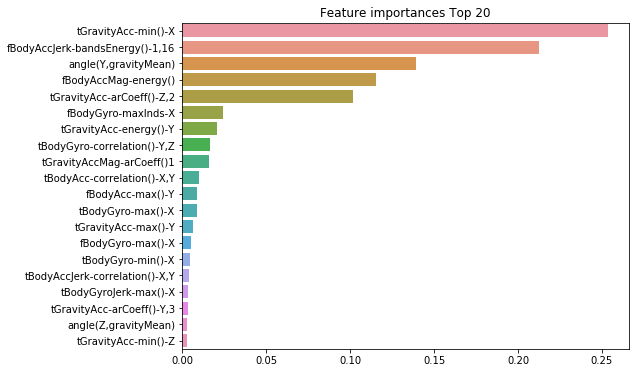

In [11]:
import seaborn as sns

ftr_importances_values = best_df_clf.feature_importances_
# Top 중요도로 정렬을 쉽게하고 Seaborn의 막대그래프로 쉽게 표현하기 위해 Series로 변환
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
# 중요도값 순으로 Series를 정렬
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

- Top 5의 피처들이 중요한것을 알 수 있다.
